# Advanced ML - Exercise 3 Notebook
By:<br>
Joel Liurner, ID: 346243579<br>
Gil Zeevi, ID: 203909320


In [ ]:
import pandas as pd
import numpy as np
import shutil
import os
import json
import pickle
from tqdm import tqdm
tqdm.pandas()
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
# !pip install --upgrade matplotlib

# Data preprocessing

In [ ]:
! cd /content/drive/MyDrive/IDCJoel/kaggle_dataset
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/IDCJoel/kaggle_dataset/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

In [ ]:
! unzip /content/drive/MyDrive/IDCJoel/kaggle_dataset/CORD-19-research-challenge.zip -d /content/drive/MyDrive/IDCJoel/kaggle_dataset

In [ ]:
base_path = "/Users/joelliurner/Desktop/cord_dataset"
extracted_path = "/Users/joelliurner/Desktop/cord_dataset/extracted"
json_schema_path = base_path+"/json_schema.txt"
metadata_path = base_path+"/metadata.csv"

In [ ]:
!cat {json_schema_path}

# JSON schema of full text documents


{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 1

In [ ]:
df_metadata = pd.read_csv(metadata_path)

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
df_metadata.sort_values('publish_time', ascending=False, inplace=True)

In [ ]:
#There is one article of 2024, and several in december 2022, ignore them
df_metadata = df_metadata[df_metadata['publish_time'] < '2022-03-26']

In [ ]:
# Drop inconsistent samples
df_metadata.dropna(subset=['sha'], inplace=True)
df_metadata.dropna(subset=['abstract'], inplace=True)
df_metadata.dropna(subset=["pdf_json_files"], inplace=True)
df_metadata.dropna(subset=["pmc_json_files"], inplace=True)
df_metadata.reset_index(inplace = True)

In [ ]:
# Keep useful articles, with text and abstract
# Extract 20k recent samples
df_sample20 = df_metadata[0:20000].copy()
#df_sample20 = df_metadata[0:20].copy()
df_sample20['text'] = None
for i in range(len(df_sample20)):
#for i in range(5):
    file_path = df_sample20.loc[i]['pmc_json_files']
    new_file_path = os.path.join(extracted_path,file_path)
    shutil.copyfile( os.path.join(base_path,file_path), new_file_path )
    with open(new_file_path) as file:
        content = json.load(file)
        text = []
        for entry in content['body_text']:
            text.append(entry['text'])
  
        text = '\n'.join(text)
    df_sample20.at[i, 'text']= text

In [ ]:
del df_metadata
df_sample20.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,text
0,884121,flrlee96,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Elsevier; PMC,Assessing face masks in the environment by mea...,10.1016/j.scitotenv.2021.152859,PMC8724021,34995587.0,no-cc,The use of face masks outside the health care ...,...,"Tesfaldet, Yacob T.; Ndeh, Nji T.",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/c86d5946ce78b0c8fc0e4...,document_parses/pmc_json/PMC8724021.xml.json,https://api.elsevier.com/content/article/pii/S...,245652163.0,"As the name implies, single-use face masks are..."
1,888988,g7ddk1hm,819e829dbefd87a2eaf166bca8dfdf8476aed245,Elsevier; Medline; PMC; WHO,Pharmaceutical compounds used in the COVID-19 ...,10.1016/j.scitotenv.2021.152691,PMC8717703,34974020.0,no-cc,"During the COVID-19 pandemic, high consumption...",...,"Morales-Paredes, Carlos Augusto; Rodríguez-Día...",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/819e829dbefd87a2eaf16...,document_parses/pmc_json/PMC8717703.xml.json,https://www.sciencedirect.com/science/article/...,245568730.0,The presence of pharmaceutical compounds and t...
2,812118,pb66cb6k,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Elsevier; Medline; PMC; WHO,Health consequences of disinfection against SA...,10.1016/j.scitotenv.2021.152832,PMC8720300,34986424.0,no-cc,Individuals who get involved in the disinfecti...,...,"Rafiee, Ata; Delgado-Saborit, Juana Maria; Sly...",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/1840b4d970cd26945d9d1...,document_parses/pmc_json/PMC8720300.xml.json,https://api.elsevier.com/content/article/pii/S...,245617000.0,"COVID-19, a disease caused by the severe acute..."
3,837564,orkeretn,0e377eaf4bc70ad866a446fa36c6d4bbd52f7bb5; 460d...,Elsevier; Medline; PMC; WHO,"Brief, parent-led, transdiagnostic cognitive-b...",10.1016/j.jad.2022.01.034,PMC8752168,35031335.0,no-cc,BACKGROUND: The COVID-19 pandemic has led to i...,...,"Guzick, Andrew G.; Leong, Alicia W.; Dickinson...",J Affect Disord,NaN,NaN,NaN,document_parses/pdf_json/0e377eaf4bc70ad866a44...,document_parses/pmc_json/PMC8752168.xml.json,https://doi.org/10.1016/j.jad.2022.01.034; htt...,245855662.0,The COVID-19 pandemic has changed nearly every...
4,807972,sd6pg3sf,f6b6be81a360f4d90553b62b95f5e15201df5ac9; 3c85...,Elsevier; Medline; PMC; WHO,Direct capture and smartphone quantification o...,10.1016/j.bios.2021.113912,PMC8701770,34973565.0,no-cc,"SARS, a new type of respiratory disease caused...",...,"Kim, Sangsik; Akarapipad, Patarajarin; Nguyen,...",Biosens Bioelectron,NaN,NaN,NaN,document_parses/pdf_json/f6b6be81a360f4d90553b...,document_parses/pmc_json/PMC8701770.xml.json,https://api.elsevier.com/content/article/pii/S...,245426397.0,We have recently witnessed the worldwide pande...


In [ ]:
df_sample20.drop(['source_x', 'doi', 'pmcid', 'pubmed_id', 'license', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'url', 's2_id'], axis=1)

,index,cord_uid,sha,title,abstract,publish_time,pdf_json_files,pmc_json_files,text
0,884121,flrlee96,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Assessing face masks in the environment by mea...,The use of face masks outside the health care ...,2022-03-25,document_parses/pdf_json/c86d5946ce78b0c8fc0e4...,document_parses/pmc_json/PMC8724021.xml.json,"As the name implies, single-use face masks are..."
1,888988,g7ddk1hm,819e829dbefd87a2eaf166bca8dfdf8476aed245,Pharmaceutical compounds used in the COVID-19 ...,"During the COVID-19 pandemic, high consumption...",2022-03-25,document_parses/pdf_json/819e829dbefd87a2eaf16...,document_parses/pmc_json/PMC8717703.xml.json,The presence of pharmaceutical compounds and t...
2,812118,pb66cb6k,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Health consequences of disinfection against SA...,Individuals who get involved in the disinfecti...,2022-03-25,document_parses/pdf_json/1840b4d970cd26945d9d1...,document_parses/pmc_json/PMC8720300.xml.json,"COVID-19, a disease caused by the severe acute..."
3,837564,orkeretn,0e377eaf4bc70ad866a446fa36c6d4bbd52f7bb5; 460d...,"Brief, parent-led, transdiagnostic cognitive-b...",BACKGROUND: The COVID-19 pandemic has led to i...,2022-03-15,document_parses/pdf_json/0e377eaf4bc70ad866a44...,document_parses/pmc_json/PMC8752168.xml.json,The COVID-19 pandemic has changed nearly every...
4,807972,sd6pg3sf,f6b6be81a360f4d90553b62b95f5e15201df5ac9; 3c85...,Direct capture and smartphone quantification o...,"SARS, a new type of respiratory disease caused...",2022-03-15,document_parses/pdf_json/f6b6be81a360f4d90553b...,document_parses/pmc_json/PMC8701770.xml.json,We have recently witnessed the worldwide pande...
...,...,...,...,...,...,...,...,...,...
19995,770507,1syhlbxn,3d3cb448ed070224af8f6940cab1eea6dac69cc6,The European Genome-phenome Archive in 2021,The European Genome-phenome Archive (EGA - htt...,2021-11-17,document_parses/pdf_json/3d3cb448ed070224af8f6...,document_parses/pmc_json/PMC8728218.xml.json,The European Genome-phenome Archive (EGA) is a...
19996,770638,wxkivq3b,53cb2c64647a2136998a5f8955d73d7bbb8bff5b,Adverse drug reactions reporting practice and ...,INTRODUCTION: timely adverse drug reactions (A...,2021-11-17,document_parses/pdf_json/53cb2c64647a2136998a5...,document_parses/pmc_json/PMC8683451.xml.json,Adverse Drug Reactions (ADRs) constitute an im...
19997,852900,a8euut84,034d787fdafaa888e699da8f69be56ad8c651579,Role of miRNAs as biomarkers of COVID-19: a sc...,Aim: miRNAs are potential biomarkers of severa...,2021-11-17,document_parses/pdf_json/034d787fdafaa888e699d...,document_parses/pmc_json/PMC8601154.xml.json,A comprehensive search of literature published...
19998,819775,omrgr0r7,8d6ece323f61d6657e70e7994701bbd9d889e584,Access to material resources and the subjectiv...,This article analyzes the relationships betwee...,2021-11-17,document_parses/pdf_json/8d6ece323f61d6657e70e...,document_parses/pmc_json/PMC8596856.xml.json,Notable importance in recent years has been as...


In [ ]:
# Save to Pickle to use this data as base for the model
df_sample20.to_pickle('df_sample20.pickle')

# Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/IDC_AdvML

/content/gdrive/.shortcut-targets-by-id/1Fg_Qoe86_zPHEpJP7qQTjfY7jrnT010g/IDC_AdvML


In [ ]:
df = pd.read_pickle('df_sample20.pickle')

In [ ]:
df[['sha', 'title', 'abstract','journal','text']].head(3)

,sha,title,abstract,journal,text
0,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Assessing face masks in the environment by mea...,The use of face masks outside the health care ...,Sci Total Environ,"As the name implies, single-use face masks are..."
1,819e829dbefd87a2eaf166bca8dfdf8476aed245,Pharmaceutical compounds used in the COVID-19 ...,"During the COVID-19 pandemic, high consumption...",Sci Total Environ,The presence of pharmaceutical compounds and t...
2,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Health consequences of disinfection against SA...,Individuals who get involved in the disinfecti...,Sci Total Environ,"COVID-19, a disease caused by the severe acute..."


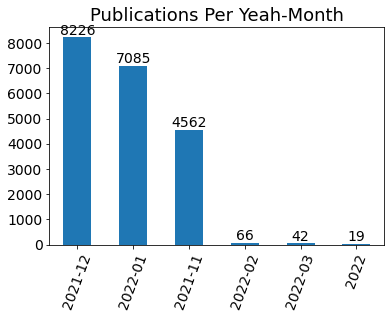

In [ ]:
ax = df['publish_time'].apply(lambda x:x[0:-3] if len(x) > 4 else x).value_counts().plot(kind = 'bar', fontsize =14, title = 'Publications Per Yeah-Month')
ax.title.set_size(18)
ax.bar_label(ax.containers[0],fontsize=14)
plt.xticks(rotation=70)
plt.show()

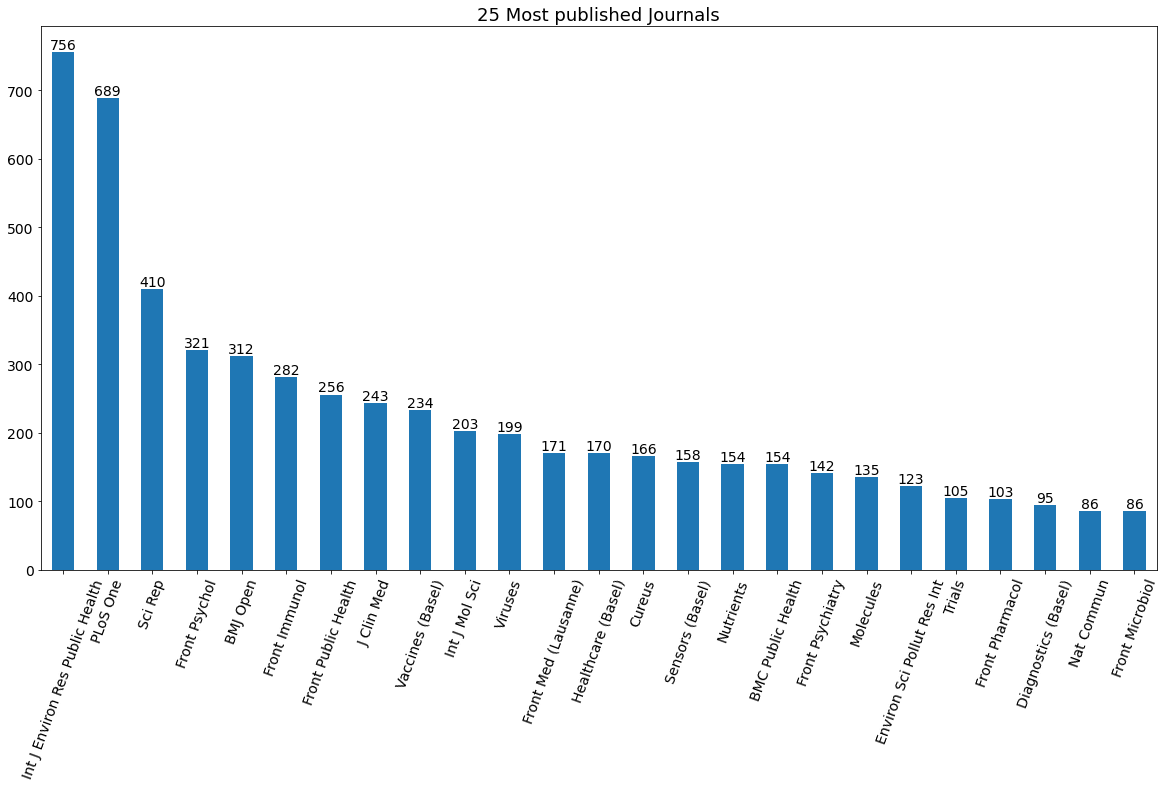

In [ ]:
ax = df['journal'].value_counts().nlargest(25).plot(kind = 'bar', fontsize =14,figsize = (20,10), title = '25 Most published Journals')
ax.title.set_size(18)
ax.bar_label(ax.containers[0],fontsize=14)
plt.xticks(rotation=70)
plt.show()

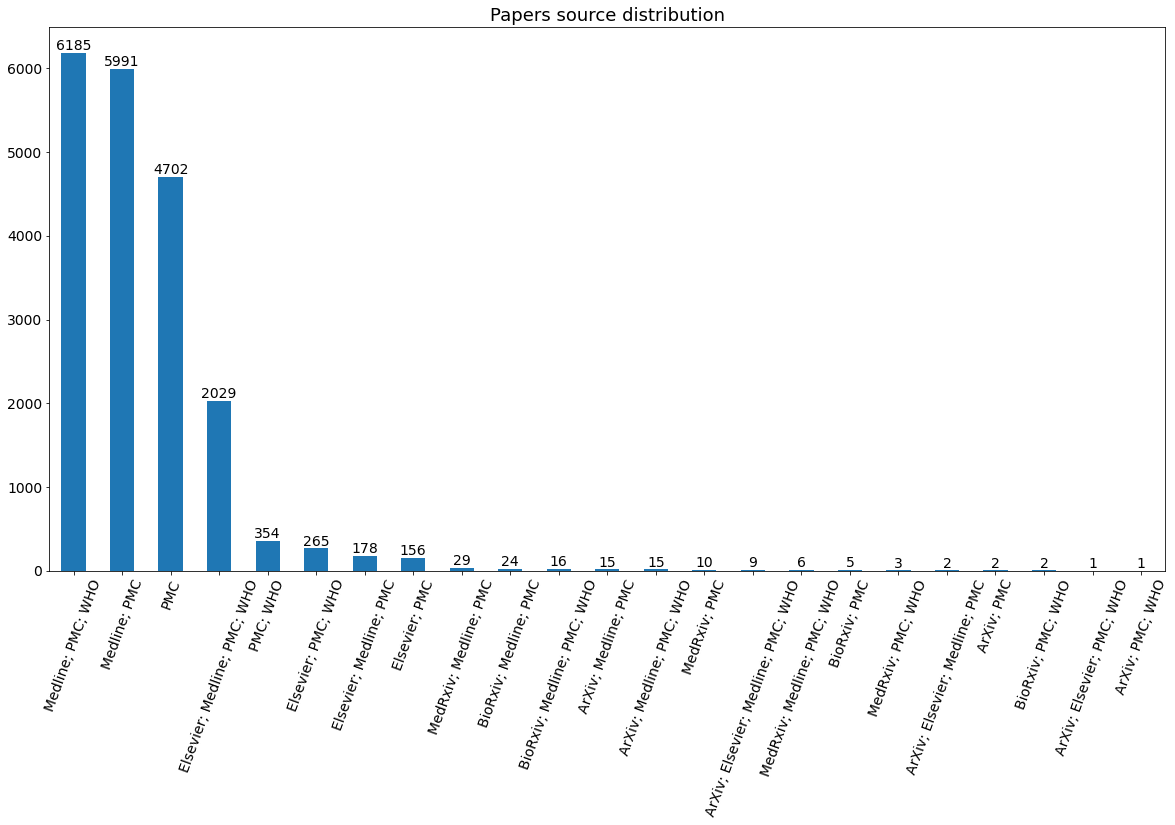

In [ ]:
ax = df['source_x'].value_counts().plot(kind = 'bar', fontsize =14,figsize = (20,10), title = 'Papers source distribution')
ax.title.set_size(18)
ax.bar_label(ax.containers[0],fontsize=14)
plt.xticks(rotation=70)
plt.show()

# Compression and similarity


In [ ]:
df_sample20 = pd.read_pickle('df_sample20.pickle')['text']
df = pd.read_pickle('df_sample20.pickle')
df_sample20.head(3)

0    As the name implies, single-use face masks are...
1    The presence of pharmaceutical compounds and t...
2    COVID-19, a disease caused by the severe acute...
Name: text, dtype: object

### Implementing Distance And Similarity metrics

In [ ]:
def NCD(x,y):
  '''
  * Similarity metric *
  Getting the Normalized Compression Distance of two objects
  using the gzip
  input: 
           x,y - objects
  returns:
           Distance \in [0,1] where:
              0 - Identical
              1 - Completely dissimilar
  '''
  xy = x + y  # concatenates objects
  x_c = gzip.compress(bytes(x, 'utf-8'))   # x compression
  y_c= gzip.compress(bytes(y, 'utf-8'))  # y compression
  xy_c = gzip.compress(bytes(xy, 'utf-8'))  #concatenated file compression
  # Calculating 'distance'
  ncd = (len(xy_c) - min(len(x_c), len(y_c))) / max(len(x_c), len(y_c))
  return ncd


In [ ]:
def BCN(x,y):
  '''
  * Distance metric *
  Based on Getting the Best-Compression Neighbor K-nn method0
  using the gzip
  input: 
           x,y - objects
  returns:
           Distance of the anchor x to an object y
  '''
  y_c= gzip.compress(bytes(y, 'utf-8'))  # y compression
  xy = x + y  # concatenates objects
  xy_c = gzip.compress(bytes(xy, 'utf-8'))  #concatenated file compression
  return (len(xy_c) - len(y_c))

## Checking k-Nearest-Papers for a sampled paper

In [ ]:
def K_nearest_papers(paper,corpus,k,method='similarity'):
  '''
  Getting the K nearest papers to an inspected paper. can be based on similarity or distance metrics
  input: 
           paper - input to be inspected
           corpus - set of papers to return the nearest subset from them
  returns:
           k nearest papers DataFrame[Title,Full text, proximity score]
  '''
  corp = pd.DataFrame(corpus.copy())
  if (corpus.text.isin(paper.text)).sum() > 0:
      corp.drop(paper.index,inplace=True)
  if method =='similarity':
      print('\nCalculating Proximity Based on Similarity\n')
      corp['Nearest']= corp.text.progress_apply(lambda x: NCD(x,paper.text.iloc[0]))
  if method =='distance':
      print('\nCalculating Proximity Based on Distance\n')
      corp['Nearest']= corp.text.progress_apply(lambda x: BCN(x,paper.text.iloc[0]))

  print('\n\nTitle Inspected',': ', paper.title.iloc[0],'\n' )
  sim_df = corp.loc[(corp['Nearest'].nsmallest(k)).index]
  for i,title in enumerate(sim_df.title.tolist()):
    print('Nearest Title', i+1, ': ', title )
  return  sim_df

In [ ]:
paper = df.sample(n=1)[['title','text']]
print(paper.title.iloc[0])

COVID-19 hospital activity and in-hospital mortality during the first and second waves of the pandemic in England: an observational study


In [ ]:
sim_df = K_nearest_papers(paper,df[['title','text']],5,method='similarity')
sim_df = K_nearest_papers(paper,df[['title','text']],5,method ='distance')
# sim_df


Calculating Proximity Based on Similarity



100%|██████████| 19999/19999 [02:11<00:00, 151.96it/s]




Title Inspected :  COVID-19 hospital activity and in-hospital mortality during the first and second waves of the pandemic in England: an observational study 

Nearest Title 1 :  First and second waves among hospitalised patients with COVID-19 with severe pneumonia: a comparison of 28-day mortality over the 1-year pandemic in a tertiary university hospital in Italy
Nearest Title 2 :  Inpatient COVID-19 mortality has reduced over time: Results from an observational cohort
Nearest Title 3 :  Risk of COVID-19 hospital admission among children aged 5–17 years with asthma in Scotland: a national incident cohort study
Nearest Title 4 :  Systemic Anti-Cancer Therapy and Metastatic Cancer Are Independent Mortality Risk Factors during Two UK Waves of the COVID-19 Pandemic at University College London Hospital
Nearest Title 5 :  Clinical Characteristics of COVID-19 Patients in a Regional Population With Diabetes Mellitus: The ACCREDIT Study

Calculating Proximity Based on Distance



100%|██████████| 19999/19999 [01:40<00:00, 198.74it/s]



Title Inspected :  COVID-19 hospital activity and in-hospital mortality during the first and second waves of the pandemic in England: an observational study 

Nearest Title 1 :  Is Omicron the last SARS-CoV-2 Variant of Concern?
Nearest Title 2 :  SARS-CoV-2 adipose tissue infection and hyperglycemia: A further step towards the understanding of severe COVID-19
Nearest Title 3 :  Papua New Guinea Under the COVID-19 Pandemic and Public Health Support from the World Health Organization
Nearest Title 4 :  Whole-Genome Sequences Analysis Displays Relationship of SARS-CoV-2 Delta Variant Between Four Local Cases and Passengers of a Flight from South Africa — Shenzhen City, Guangdong Province, China, June 2021
Nearest Title 5 :  In a search of a protective titer: Do we or do we not need to know?


In [ ]:
paper = df.sample(n=1)[['title','text']]
print(paper.title.iloc[0])

High Prevalence of Chronic Kidney Disease Among People Living with Hypertension in Rural Sierra Leone: A Cross-Sectional Study


In [ ]:
sim_df = K_nearest_papers(paper,df[['title','text']],5,method='similarity')


Calculating Proximity Based on Similarity



100%|██████████| 19999/19999 [02:10<00:00, 152.77it/s]



Title Inspected :  High Prevalence of Chronic Kidney Disease Among People Living with Hypertension in Rural Sierra Leone: A Cross-Sectional Study 

Nearest Title 1 :  The incidence, risk factors and outcomes of acute kidney injury in critically ill patients undergoing emergency surgery: a prospective observational study
Nearest Title 2 :  A semi-systematic review on hypertension and dyslipidemia care in Egypt—highlighting evidence gaps and recommendations for better patient outcomes
Nearest Title 3 :  Anxiety, Depression, and Common Chronic Diseases, and Their Association With Social Determinants in Saudi Primary Care
Nearest Title 4 :  High Fasting Blood Glucose Level With Unknown Prior History of Diabetes Is Associated With High Risk of Severe Adverse COVID-19 Outcome
Nearest Title 5 :  Regional Differences in COVID-19 Mortality Rates in the Kingdom of Saudi Arabia: A Simulation of the New Model of Care


In [ ]:
sim_df

,title,text,Nearest
1097,"The incidence, risk factors and outcomes of ac...",Acute kidney injury (AKI) is a common postoper...,0.895192
14985,A semi-systematic review on hypertension and d...,Noncommunicable diseases (NCDs) were responsib...,0.896272
18295,"Anxiety, Depression, and Common Chronic Diseas...",The last few decades have seen a prominent shi...,0.897569
13302,High Fasting Blood Glucose Level With Unknown ...,"As of August 10, 2021, more than 204 million c...",0.898757
7847,Regional Differences in COVID-19 Mortality Rat...,"On 5 January 2021, the global mortality rates ...",0.899406


From the similarity based calculation, we can interpret the nearest papers  are somehow related in a matter that they talk about: covid waves, mortality and cohort studies.

**Creating an 'affinity matrix' and 'distance matrix' between each text to others**

In [ ]:
samp_1000 = df_sample20.sample(n=1000)
samp_1000 = samp_1000.reset_index()

In [ ]:
#initialize affinity matrix

dist_mat =np.zeros((len(samp_1000),len(samp_1000)))
aff_mat = np.zeros((len(samp_1000),len(samp_1000)))
#get upper triangular metrix indices - this command will help up save running time by running on only one loop instead of two - really significant in Python
arr=np.triu_indices(len(dist_mat))
#calculate only for upper triangular matrix and then apply symmetry
for j in tqdm(range(len(arr[0]))):
  if arr[0][j] == arr[1][j]:
    #the diagonal is 0 of course
    dist_mat[arr[0][j]][arr[1][j]] = 0 
    aff_mat[arr[0][j]][arr[1][j]] = 0
    continue
  else:
    dist_mat[arr[0][j]][arr[1][j]] = BCN(samp_1000.iloc[arr[0][j]].text,samp_1000.iloc[arr[1][j]].text)
    aff_mat[arr[0][j]][arr[1][j]] = NCD(samp_1000.iloc[arr[0][j]].text,samp_1000.iloc[arr[1][j]].text)

  dist_mat[arr[1][j]][arr[0][j]] = dist_mat[arr[0][j]][arr[1][j]]
  aff_mat[arr[1][j]][arr[0][j]] = aff_mat[arr[0][j]][arr[1][j]]
with open('dist_matrix.pickle', 'wb') as f:
  pickle.dump(dist_mat, f)
f.close()
with open('aff_matrix.pickle', 'wb') as f:
  pickle.dump(aff_mat, f)
f.close()
samp_1000.to_csv('samp_1000.csv')

100%|██████████| 500500/500500 [1:43:13<00:00, 80.81it/s]


In [ ]:
#load pre-computed files and 1000 samples dataframe:
samp_1000 = pd.read_csv('samp_1000.csv').drop(labels=['Unnamed: 0'],axis=1)
with open('aff_matrix.pickle', "rb") as f:
  aff_mat = pickle.load(f)
f.close()
with open('dist_matrix.pickle', "rb") as f:
  dist_mat = pickle.load(f)
f.close()

In [ ]:
samp_1000

,index,text
0,12542,Switzerland has experienced two lockdowns so f...
1,5271,"Coronavirus disease 2019 (COVID-19), first ide..."
2,17542,Severe Acute Respiratory Syndrome Coronavirus ...
3,3877,The Development of chemically defined cell cul...
4,5434,A high number of cluster infections have been ...
...,...,...
995,1256,Healthcare delivery is challenging and complex...
996,9619,A recent report by the World Health Organizati...
997,4661,"In recent years, we have witnessed continuous ..."
998,793,"The COVID-19 pandemic reflects a unique, chron..."


sanity check to see if the compressed affinity matrix matches to papers

In [ ]:
assert aff_mat[110][3] == NCD(samp_1000.iloc[3].text,samp_1000.iloc[110].text)
assert aff_mat[6][17] == NCD(samp_1000.iloc[6].text,samp_1000.iloc[17].text)
assert dist_mat[110][3] == BCN(samp_1000.iloc[3].text,samp_1000.iloc[110].text)
assert dist_mat[6][17] == BCN(samp_1000.iloc[6].text,samp_1000.iloc[17].text)

##Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn import metrics

In [ ]:
condensed_dist_matrix = squareform(dist_mat)
condensed_aff_matrix = squareform(aff_mat)

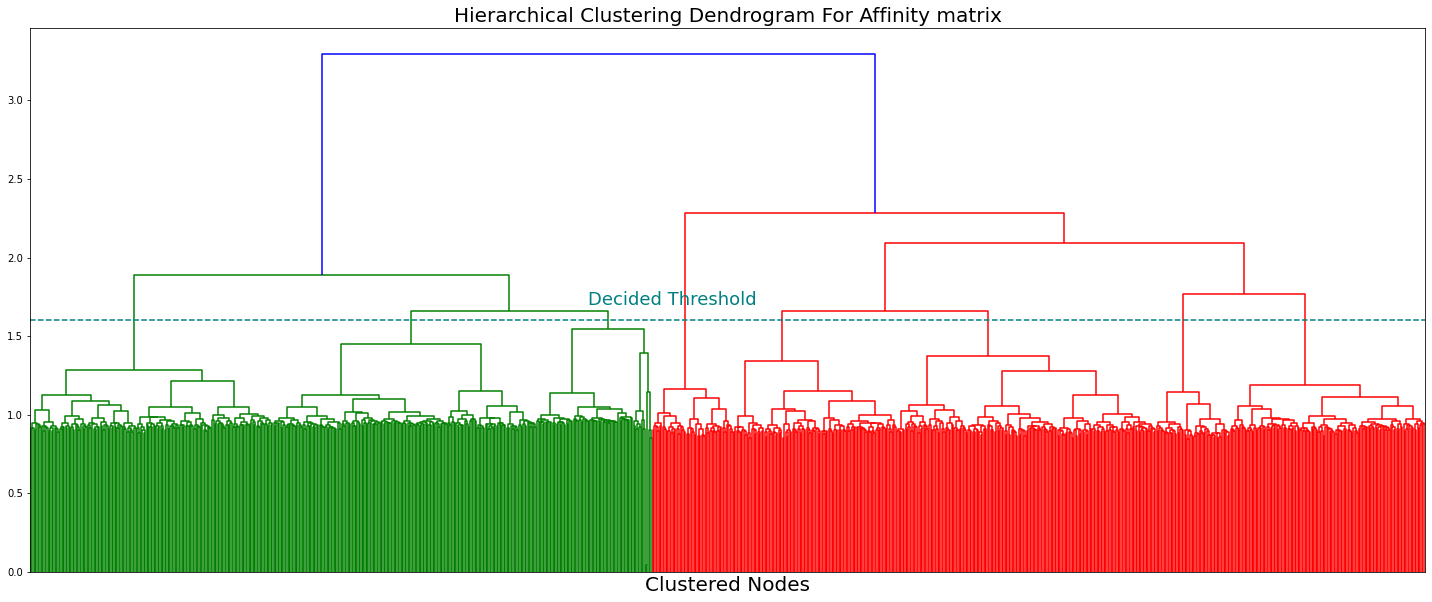

In [ ]:
Zaff = hierarchy.linkage(condensed_aff_matrix, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Zaff)
plt.axhline(y=1.6, color='teal', linestyle='--')
plt.title("Hierarchical Clustering Dendrogram For Affinity matrix",fontsize = 20)
plt.xlabel("Clustered Nodes",fontsize = 20)
plt.xticks([])
plt.text(s='Decided Threshold',x= 4000,y=1.7,fontsize=18,color = 'teal')
plt.show()

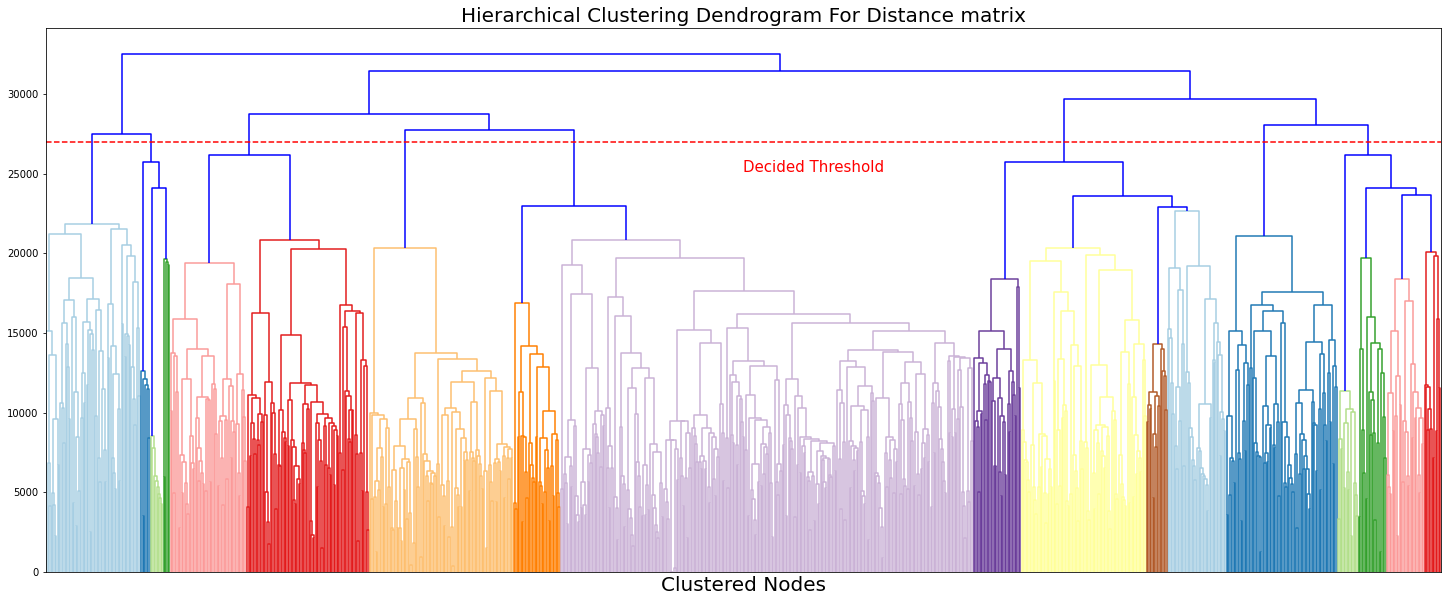

In [ ]:
Zdist = hierarchy.linkage(condensed_dist_matrix, method='complete')
hierarchy.set_link_color_palette(list(sns.color_palette("Paired").as_hex()))
fig = plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Zdist)
plt.title("Hierarchical Clustering Dendrogram For Distance matrix",fontsize = 20)
plt.xlabel("Clustered Nodes",fontsize = 20)
plt.xticks([])
plt.text(s='Decided Threshold',x= 5000,y=25100,fontsize=15,color = 'red')
plt.axhline(y=27000, color='r', linestyle='--')
hierarchy.set_link_color_palette(None)
plt.show()

In [ ]:
labels = hierarchy.fcluster(Zaff, t=1.6, criterion='distance') # for affinity matrix and ward method
# labels = hierarchy.fcluster(Zdist, t=27000, criterion='distance') # for distance matrix and complete method
print(f"Number of Clusters in Distance Dendogram: {np.unique(hierarchy.fcluster(Zaff, t=1.6, criterion='distance')).shape[0]}")
print(f"Number of Clusters in Affinity Dendogram: {np.unique(hierarchy.fcluster(Zdist, t=27000, criterion='distance')).shape[0]}")
labels.max(),labels.min()

(8, 1)

**Save Labels to Dataframe so we assign each sample to a cluster**

In [ ]:
samp_1000['labels'] = labels
samp_1000.to_csv('samp_1000_labeled.csv')
samp_1000.head()

,index,text,labels
0,12542,Switzerland has experienced two lockdowns so f...,8
1,5271,"Coronavirus disease 2019 (COVID-19), first ide...",4
2,17542,Severe Acute Respiratory Syndrome Coronavirus ...,2
3,3877,The Development of chemically defined cell cul...,3
4,5434,A high number of cluster infections have been ...,6


In [ ]:
# Check some samples in one cluster. 
cluster_check_label = 1
sample_from_cluster = samp_1000[ samp_1000.labels == cluster_check_label ].sample(n=10)
sample_from_cluster = sample_from_cluster.reset_index()
sample_from_cluster = sample_from_cluster.rename(columns={"level_0": "sample_1000_index"})
sample_from_cluster

,sample_1000_index,index,text,labels
0,191,14340,"Conceivably, some of the most innovative resea...",1
1,959,15960,Due to its high strength and good mechanical p...,1
2,459,4778,"According to Global Cancer Observatory, cancer...",1
3,652,13614,Asthma is a chronic inflammatory disease affec...,1
4,469,6816,Acute myocardial infarction (AMI) is a conditi...,1
5,360,9549,"Acute Respiratory Distress Syndrome (ARDS), a ...",1
6,487,8971,The 2019 Coronavirus Disease (COVID-19) pandem...,1
7,732,11877,The COVID-19 (Coronavirus Disease 2019) pandem...,1
8,189,6757,Malnutrition is one of the main health problem...,1
9,53,16020,Chronic obstructive pulmonary disease (COPD) i...,1


In [ ]:
# Get 1 sample from each cluster
different_cluster_samples = samp_1000[ samp_1000.labels == cluster_check_label ].sample(n=1)
for i in range(2, max(labels)+1):
  if i != cluster_check_label:
    different_cluster_samples = pd.concat( [different_cluster_samples, samp_1000[ samp_1000.labels == i ].sample(n=1)], axis=0)

different_cluster_samples = different_cluster_samples.reset_index()
different_cluster_samples = different_cluster_samples.rename(columns={"level_0": "sample_1000_index"})
different_cluster_samples

,sample_1000_index,index,text,labels
0,952,13123,Melanoma is the least common but deadliest typ...,1
1,988,11820,The emerging Omicron Variant of Concern (VOC) ...,2
2,198,3632,"As the number of defined PIDDs increases, clas...",3
3,818,9479,The first cases of a novel coronavirus infecti...,4
4,209,11233,Nosocomial infection (NI) or hospital-acquired...,5
5,446,6008,Cathelicidin is a generic name that can refer ...,6
6,59,9390,Aging is one of the most prominent features of...,7
7,525,9895,Viewing certain static patterns can result in ...,8


**We take one sample and analyze it agains all clusters by considering its distance and similarity**

In [ ]:
sample_to_analyse = samp_1000[ samp_1000.labels == cluster_check_label ].sample(n=1)
sample_to_analyse = sample_to_analyse.reset_index()
sample_to_analyse = sample_to_analyse.rename(columns={"level_0": "sample_1000_index"})

dist_to_each_cluster = {}
aff_to_each_cluster = {}
for i in range(samp_1000.shape[0]):
  distance = dist_mat[ sample_to_analyse['sample_1000_index'][0], samp_1000.index[i] ]
  affinity = aff_mat[ sample_to_analyse['sample_1000_index'][0], samp_1000.index[i] ]
  if samp_1000['labels'][i] in dist_to_each_cluster.keys():
    dist_to_each_cluster[samp_1000['labels'][i]].append(distance)
    aff_to_each_cluster[samp_1000['labels'][i]].append(affinity)
  else:
      dist_to_each_cluster[samp_1000['labels'][i]] = [distance]
      aff_to_each_cluster[samp_1000['labels'][i]] = [affinity]

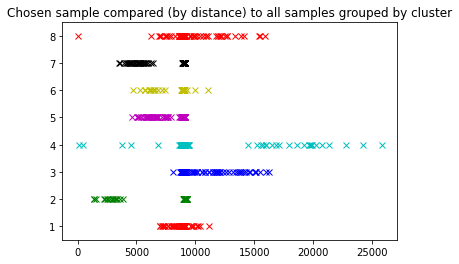

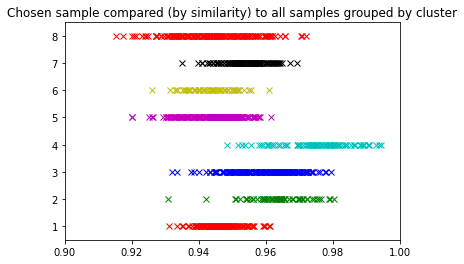

In [ ]:
colors = ['r','g','b','c','m','y','k','r']

#distance
i = 1
for k in dist_to_each_cluster.keys() :
  plt.plot(np.asarray(dist_to_each_cluster[k]), np.zeros_like(dist_to_each_cluster[k])+i, 'x', color = colors[i-1])
  i += 1
plt.title
plt.ylim([0.5, 8.5])
plt.title('Chosen sample compared (by distance) to all samples grouped by cluster')
plt.show()

#Affinity
i = 1
for k in dist_to_each_cluster.keys() :
  plt.plot(np.asarray(aff_to_each_cluster[k]), np.zeros_like(aff_to_each_cluster[k])+i, 'x', color = colors[i-1])
  i += 1

plt.ylim([0.5, 8.5])
plt.xlim([0.9, 1])
plt.title('Chosen sample compared (by similarity) to all samples grouped by cluster')
plt.show()

**We take some samples of one cluster to check their titles and compare**

In [ ]:
#- check they have similar titles

cluster_sample_text_list = []
for i in range(sample_from_cluster.shape[0]):
  title = df_sample20.iloc[ sample_from_cluster['index'][i]]['title']
  text = df_sample20.iloc[ sample_from_cluster['index'][i]]['text']
  print('Title ', i, ': ', title )
  cluster4_sample_text_list.append(text)


Title  0 :  Denaturation of the SARS-CoV-2 spike protein under non-thermal microwave radiation
Title  1 :  Effect of Heat Treatment on Residual Stress of Cold Sprayed Nickel-based Superalloys
Title  2 :  Safety, Stability, and Therapeutic Efficacy of Long-Circulating TQ-Incorporated Liposomes: Implication in the Treatment of Lung Cancer
Title  3 :  Imiquimod Boosts Interferon Response, and Decreases ACE2 and Pro-Inflammatory Response of Human Bronchial Epithelium in Asthma
Title  4 :  Protective Effects of Allicin on Acute Myocardial Infarction in Rats via Hydrogen Sulfide-mediated Regulation of Coronary Arterial Vasomotor Function and Myocardial Calcium Transport
Title  5 :  Acute Respiratory Distress Syndrome and COVID-19: A Literature Review
Title  6 :  Epidemiological Characteristics of Hospitalized Patients with Moderate versus Severe COVID-19 Infection: A Retrospective Cohort Single Centre Study
Title  7 :  Vascular Damage, Thromboinflammation, Plasmablast Activation, T-Cell Dysr

At a glance, we could say that the topics they talk are related to “heat” and “studies about treatments”.

**We take all texts from each cluster and obtain the most relevant words**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def tfidf_words(text,n_top=25,by='title'):

  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words='english')
  tfidf = tfidf_vectorizer.fit_transform(text)

  # sort by importance
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]

  # get words
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

  return tfidf_feature_names[importance[:n_top]]

In [ ]:
cluster_words_dict = {}
#common words in all texts, to remove
common_words = ['patients', 'patient', 'covid', 'cov', '19', 'et', 'al', 'sars', 'health', 'used', 'using', 'cell', 'cells', 'participants', 'study', 'data', 'fig', 'figure', '2020', 'pandemic', 'usepackage']
title_list = []
text_list = []

for label in np.unique(labels):
  cluster_samples = samp_1000[ samp_1000.labels == label ]
  text_in_cluster = df_sample20.iloc[cluster_samples['index'].values].text
  #get all texts from each cluster
  for t in text_in_cluster:
    text_list.append(t)
  #get relevant words from the cluster
  words = tfidf_words(text_list)

  #remove common words
  for w in common_words:
    if w in words: 
      index = np.argwhere(words==w)
      words = np.delete(words,index)
  cluster_words_dict[label] = words
  text_list = []



In [ ]:
for k in cluster_words_dict.keys():
  print('Cluster ',k, 'frequent words: ', cluster_words_dict[k])
  print('')

Cluster  1 frequent words:  ['protein' 'ml' 'infection' 'viral' 'expression' 'samples' 'il' 'virus'
 'compounds' 'based' 'analysis' 'binding' 'treatment']

Cluster  2 frequent words:  ['model' 'students' 'learning' 'research' 'results' 'social' 'care' 'use'
 'studies' 'information' 'number' 'models' 'performance' 'people']

Cluster  3 frequent words:  ['der' 'die' 'protein' 'und' 'social' 'different' 'based' 'reported'
 'people' 'high' 'specific' 'time' 'work']

Cluster  4 frequent words:  ['vaccination' 'vaccine' 'infection' 'reported' 'case' 'cases' 'day'
 '2021' 'clinical' 'symptoms' 'test' 'thrombosis' 'treatment' 'omicron']

Cluster  5 frequent words:  ['care' 'disease' 'medical' 'infection' 'day' 'treatment' 'studies'
 'reported' 'mortality' 'risk' 'cases' 'survey' 'clinical' 'group'
 'students']

Cluster  6 frequent words:  ['studies' 'treatment' 'risk' 'reported' 'group' 'infection' 'disease'
 'results' 'clinical' 'table' 'analysis' 'test' 'use']

Cluster  7 frequent words:  ['

On high level, we can identify topics of the papers per cluster. As we can see, these are not extremely conclusive and sometimes overlap but can represent the group. 


*   Cluster 1 topics: *virus and its structure*
*   Cluster 2 topics: *Research and studies*
*   Cluster 3 topics: *Statistics and measured results*
*   Cluster 4 topics: *Vaccine and treatments*
*   Cluster 5 and 6 topics: *Risks results and mortality*
*   Cluster 7 and 8 topics: *Treatments and studies on children*


In [ ]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(40, 20)) 
for label in np.unique(labels):
  cluster_samples = samp_1000[ samp_1000.labels == label ]
  title_in_cluster = df_sample20.iloc[cluster_samples['index'].values].title
  text = " ".join(title for title in title_in_cluster)
  wordcloud = WordCloud(collocations = False, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
  plt.subplot(2,4,label)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title('Cluster '+ str(label))
plt.show()

### Clustering  a sample based on the clustered 1000 samples:

In [ ]:
samp_1000

,index,text,labels
0,12542,Switzerland has experienced two lockdowns so f...,8
1,5271,"Coronavirus disease 2019 (COVID-19), first ide...",4
2,17542,Severe Acute Respiratory Syndrome Coronavirus ...,2
3,3877,The Development of chemically defined cell cul...,3
4,5434,A high number of cluster infections have been ...,6
...,...,...,...
995,1256,Healthcare delivery is challenging and complex...,6
996,9619,A recent report by the World Health Organizati...,8
997,4661,"In recent years, we have witnessed continuous ...",2
998,793,"The COVID-19 pandemic reflects a unique, chron...",8


In [ ]:
def assign_cluster(train,paper): 
    tmpdf = train.copy()
    tmpdf['Similarity']= tmpdf.text.progress_apply(lambda x: NCD(x,paper.text.iloc[0]))
    with warnings.catch_warnings():
      warnings.simplefilter('ignore')
      mean_table= tmpdf.groupby(['labels'])['Similarity'].mean()
      clus_label = mean_table.idxmin()
    print(f"\n\nBy Similarity, the Closest Cluster is {clus_label}")
    return mean_table,clus_label #return values of proximity for each of the clusters and the closest cluster 

### Assign a sample into cluster

In [ ]:
#get uninspected samples from data
untouched =  df[~df.index.isin(samp_1000['index'].values)]
paper = untouched.sample(n=1)
assert samp_1000.text.isin(paper.text).sum() == 0 #a double check its not really inside the 'training data' 
print(paper.title.iloc[0])

Expanded Pharmacy Practice Implementation: Lessons from Remote Practice


In [ ]:
res,lab = assign_cluster(samp_1000,paper)
res

100%|██████████| 1000/1000 [00:06<00:00, 152.97it/s]



By Similarity, the Closest Cluster is 8


labels
1    0.949934
2    0.948419
3    0.972144
4    0.954155
5    0.932908
6    0.928895
7    0.931558
8    0.925285
Name: Similarity, dtype: float64

**Clustrer the 20,000 samples**

Only code provided, without execution, as it would take approximately 45 hours to run

In [ ]:
def assign_clusters_full(paper,train): 
    tmpdf = train.copy()
    tmpdf['Similarity']= tmpdf.text.apply(lambda x: NCD(x,paper.text))
    with warnings.catch_warnings():
      warnings.simplefilter('ignore')
      clus_label = tmpdf.groupby(['labels'])['Similarity'].mean().idxmin()
    return clus_label

In [ ]:
untouched = untouched.drop(['index'],axis=1).reset_index()

In [ ]:
untouched['cluster'] = untouched.progress_apply(assign_clusters_full,train = samp_1000,axis = 1)